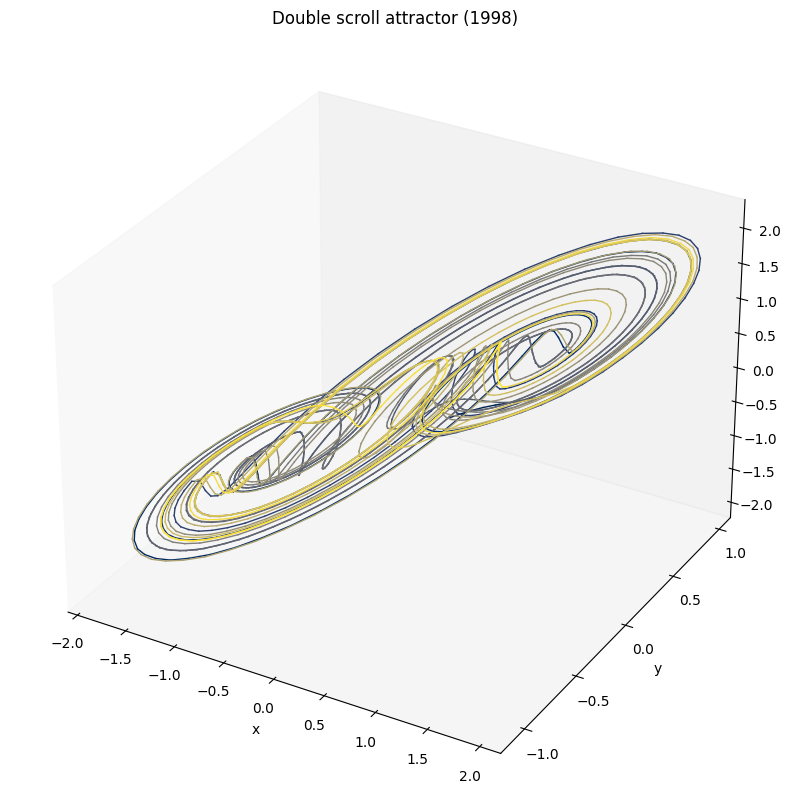

In [12]:
from reservoirpy.datasets import doublescroll
import matplotlib.pyplot as plt
from reservoirpy.nodes import Reservoir, Ridge
import numpy as np
timesteps = 2000
x0 = [0.37926545, 0.058339, -0.08167691]
X = doublescroll(timesteps, x0=x0, method="RK23")
fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(111, projection='3d')
ax.set_title("Double scroll attractor (1998)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.grid(False)

for i in range(timesteps-1):
    ax.plot(X[i:i+2, 0], X[i:i+2, 1], X[i:i+2, 2], color=plt.cm.cividis(255*i//timesteps), lw=1.0)

plt.show()

In [ ]:
from reservoirpy.observables import nrmse, rsquare
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, x_test, y_train, y_test = dataset
    
    # You can access anything you put in the config file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances to be sure there is no bias in the results due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=N, 
            sr=sr, 
            lr=lr, 
            input_scaling=input_scaling, 
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}
import json

hyperopt_config = {
    "exp": "hyperopt-multiscroll",    # the experimentation name
    "hp_max_evals": 5,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["choice", 500],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [ ]:
train_len=1000
forecast=2
X_train=X[:train_len]
Y_train=X[forecast:train_len+forecast]
X_test=X[train_len:-forecast]
Y_test=X[train_len+forecast:]
dataset=(X_train,X_test,Y_train,Y_test)

In [ ]:
from reservoirpy.datasets import to_forecasting

X_train, X_test, Y_train, Y_test = to_forecasting(X, forecast=forecast, test_size=train_len-forecast)

In [ ]:
from reservoirpy.hyper import parallel_research
best = parallel_research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

  0%|          | 1/200 [00:11<37:06, 11.19s/trial, best loss=0.368]